In [1]:

import os, glob, re, gzip, shutil, json
from os.path import join
import pathlib
import numpy as np
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn import image, plotting
import argparse
from nilearn.image import new_img_like, resample_to_img, math_img
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

In [2]:
__author__ = "Heejung Jung"
__copyright__ = "Spatial Topology Project"
__credits__ = ["Heejung"] # people who reported bug fixes, made suggestions, etc. but did not actually write the code.
__license__ = "MIT"
__version__ = "0.0.1"
__maintainer__ = "Heejung Jung"
__email__ = "heejung.jung@colorado.edu"
__status__ = "Development" 

# main_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue'
main_dir = '/Volumes/spacetop_projects_cue'


In [18]:
contrast_list = {
    'P_VC_STIM_cue_high_gt_low', 'V_PC_STIM_cue_high_gt_low', 'C_PV_STIM_cue_high_gt_low',
    'P_VC_STIM_stimlin_high_gt_low', 'V_PC_STIM_stimlin_high_gt_low', 'C_PV_STIM_stimlin_high_gt_low',
    'P_VC_STIM_stimquad_med_gt_other', 'V_PC_STIM_stimquad_med_gt_other', 'C_PV_STIM_stimquad_med_gt_other',
    'P_VC_STIM_cue_int_stimlin','V_PC_STIM_cue_int_stimlin', 'C_PV_STIM_cue_int_stimlin',
    'P_VC_STIM_cue_int_stimquad','V_PC_STIM_cue_int_stimquad','C_PV_STIM_cue_int_stimquad',
    'motor',
    'P_simple_STIM_cue_high_gt_low',      'V_simple_STIM_cue_high_gt_low', 'C_simple_STIM_cue_high_gt_low',
    'P_simple_STIM_stimlin_high_gt_low',  'V_simple_STIM_stimlin_high_gt_low', 'C_simple_STIM_stimlin_high_gt_low',
    'P_simple_STIM_stimquad_med_gt_other','V_simple_STIM_stimquad_med_gt_other', 'C_simple_STIM_stimquad_med_gt_other',
    'P_simple_STIM_cue_int_stimlin',      'V_simple_STIM_cue_int_stimlin', 'C_simple_STIM_cue_int_stimlin',
    'P_simple_STIM_cue_int_stimquad',     'V_simple_STIM_cue_int_stimquad','C_simple_STIM_cue_int_stimquad',
    'P_simple_STIM_highcue_highstim',     'P_simple_STIM_highcue_medstim', 'P_simple_STIM_highcue_lowstim',
    'P_simple_STIM_lowcue_highstim',      'P_simple_STIM_lowcue_medstim', 'P_simple_STIM_lowcue_lowstim',
    'V_simple_STIM_highcue_highstim',     'V_simple_STIM_highcue_medstim', 'V_simple_STIM_highcue_lowstim',
    'V_simple_STIM_lowcue_highstim',      'V_simple_STIM_lowcue_medstim', 'V_simple_STIM_lowcue_lowstim',
    'C_simple_STIM_highcue_highstim',    'C_simple_STIM_highcue_medstim', 'C_simple_STIM_highcue_lowstim',
    'C_simple_STIM_lowcue_highstim',    'C_simple_STIM_lowcue_medstim', 'C_simple_STIM_lowcue_lowstim',
    'P_VC_CUE_cue_high_gt_low','V_PC_CUE_cue_high_gt_low','C_PV_CUE_cue_high_gt_low',
    'P_simple_CUE_cue_high_gt_low','V_simple_CUE_STIM_cue_high_gt_low','C_simple_CUE_cue_high_gt_low',
    'G_simple_CUE_cue_high_gt_low',
    'P_VC_STIM', 'V_PC_STIM', 'C_PV_STIM'
}

### load mask

In [3]:
imgfname = join(main_dir, 'analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz')
ref_img = image.load_img(imgfname)

mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine=ref_img.affine, target_shape=ref_img.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img=mask_img, smoothing_fwhm=6,
                                            target_affine=ref_img.affine, target_shape=ref_img.shape, 
                                            memory_level=1)

## single trial data
### a) load singletrial group data

In [4]:
# load singletrial group data
beta_dir = join(main_dir, 'analysis/fmri/nilearn/deriv05_singletrialnpy')
suballLv = np.load(join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_cuetype-low.npy"))
suballHv = np.load(join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_cuetype-high.npy"))

with open(join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_cuetype-high.json"), 'r') as file:
    suballHjson = json.load(file)
with open(join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_cuetype-low.json"), 'r') as file:
    suballLjson = json.load(file)
# identify intersection of high and low cue arrays 
non_intersection = list(set(suballHjson['sub']).symmetric_difference(set(suballLjson['sub'])))
intersection = sorted(list(set(suballHjson['sub']).intersection(set(suballLjson['sub']))))
print(f"* any high trials that are non in low pain trials?: {non_intersection}")
print(f"* intersection of subjects with high and low pain trials?: {intersection}")

* any high trials that are non in low pain trials?: []
* intersection of subjects with high and low pain trials?: ['sub-0002', 'sub-0003', 'sub-0004', 'sub-0005', 'sub-0006', 'sub-0007', 'sub-0008', 'sub-0009', 'sub-0010', 'sub-0011', 'sub-0013', 'sub-0014', 'sub-0015', 'sub-0016', 'sub-0017', 'sub-0018', 'sub-0019', 'sub-0021', 'sub-0023', 'sub-0024', 'sub-0025', 'sub-0026', 'sub-0028', 'sub-0029', 'sub-0030', 'sub-0031', 'sub-0032', 'sub-0033', 'sub-0035', 'sub-0036', 'sub-0037', 'sub-0038', 'sub-0039', 'sub-0040', 'sub-0041', 'sub-0043', 'sub-0044', 'sub-0047', 'sub-0050', 'sub-0051', 'sub-0052', 'sub-0053', 'sub-0055', 'sub-0056', 'sub-0057', 'sub-0058', 'sub-0059', 'sub-0060', 'sub-0061', 'sub-0062', 'sub-0063', 'sub-0064', 'sub-0066', 'sub-0068', 'sub-0069', 'sub-0070', 'sub-0073', 'sub-0074', 'sub-0076', 'sub-0077', 'sub-0078', 'sub-0079', 'sub-0080', 'sub-0081', 'sub-0082', 'sub-0083', 'sub-0084', 'sub-0085', 'sub-0086', 'sub-0087', 'sub-0088', 'sub-0089', 'sub-0090', 'sub-0091

### b) apply mask to each single trial (shape: subjects x voxels)     

In [5]:
x,y,z=ref_img.shape
Hp = []
Lp = []
for index in range(suballHv.shape[0]):

    Hp.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    Lp.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )

fmri_masked_stimhighp = np.vstack(Hp)
fmri_masked_stimlowp = np.vstack(Lp)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighp, fmri_masked_stimlowp, axis=0, nan_policy='propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

singletrial_t = nifti_masker.inverse_transform(tvalues)

In [29]:
singletrial_t

## SPM contrast 
### a) stack SPM contrasts and T maps

In [65]:
join(main_dir, 'analysis/fmri/spm/univariate/model03_18reg/1stlevel', sub, f'*con_{contrast_index:04d}.nii')

'/Volumes/spacetop_projects_cue/analysis/fmri/spm/univariate/model03_18reg/1stlevel/sub-0111/*con_0057.nii'

In [72]:
main_dir
con_list = glob.glob(join(main_dir, 'analysis/fmri/spm/univariate/model03_18reg/1stlevel', '**', f'*con_{contrast_index:04d}.nii'), recursive='**')
con_niis = image.concat_imgs(con_list)
from pathlib import Path

target_dir = Path(join(main_dir, 'analysis/fmri/spm/univariate/model03_18reg/1stlevel'))
subcon = [p.name for p in target_dir.iterdir() if p.is_dir() and p.name.startswith("sub-")]
print(subcon)


['sub-0050', 'sub-0124', 'sub-0032', 'sub-0080', 'sub-0026', 'sub-0030', 'sub-0019', 'sub-0084', 'sub-0076', 'sub-0120', 'sub-0061', 'sub-0070', 'sub-0062', 'sub-0127', 'sub-0107', 'sub-0066', 'sub-0041', 'sub-0091', 'sub-0115', 'sub-0090', 'sub-0079', 'sub-0133', 'sub-0114', 'sub-0106', 'sub-0077', 'sub-0073', 'sub-0128', 'sub-0047', 'sub-0094', 'sub-0051', 'sub-0064', 'sub-0035', 'sub-0109', 'sub-0082', 'sub-0071', 'sub-0122', 'sub-0075', 'sub-0028', 'sub-0039', 'sub-0087', 'sub-0116', 'sub-0068', 'sub-0123', 'sub-0102', 'sub-0033', 'sub-0078', 'sub-0119', 'sub-0025', 'sub-0089', 'sub-0018', 'sub-0129', 'sub-0083', 'sub-0052', 'sub-0085', 'sub-0074', 'sub-0055', 'sub-0060', 'sub-0093', 'sub-0031', 'sub-0126', 'sub-0118', 'sub-0099', 'sub-0017', 'sub-0023', 'sub-0088', 'sub-0086', 'sub-0069', 'sub-0098', 'sub-0097', 'sub-0015', 'sub-0132', 'sub-0058', 'sub-0043', 'sub-0095', 'sub-0092', 'sub-0013', 'sub-0100', 'sub-0103', 'sub-0104', 'sub-0044', 'sub-0040', 'sub-0029', 'sub-0101', 'su

In [70]:
plotting.plot_stat_map(con_niis)

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See https://nilearn.github.io/stable/manipulating_images/input_output.html.

In [59]:
# mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
# mask_img = nilearn.masking.compute_epi_mask(mask, target_affine=ref_img.affine, target_shape=ref_img.shape)

# spm_nifti_masker = nilearn.maskers.NiftiMasker(mask_img=mask_img, smoothing_fwhm=None,
#                                             target_affine=ref_img.affine, target_shape=ref_img.shape, 
#                                             memory_level=1)
# con = []
# con_not_in_SPM = []
# subcon = []

# contrast_of_interest = 'P_simple_STIM_stimlin_high_gt_low'
# if contrast_of_interest in contrast_list:
#     contrast_index = list(contrast_list).index(contrast_of_interest)
# print(f"contrast index {contrast_index}")

# # TODO: convoluted. find a better way to glob sub directories that start with sub-XX
# from pathlib import Path
# your_directory_path = '/Volumes/spacetop_projects_cue/analysis/fmri/spm/univariate/model03_18reg/1stlevel'
# directory = Path(your_directory_path)
# subdirectories = [p.name for p in directory.iterdir() if p.is_dir()]

# con_list = glob.glob(join(main_dir, 'analysis/fmri/spm/univariate/model03_18reg/1stlevel', sub, f'*con_{contrast_index:04d}.nii'))
# nilearn.image.concat_imgs(niimgs, dtype=<class 'numpy.float32'>, ensure_ndim=None, memory=Memory(location=None), memory_level=0, auto_resample=False, verbose=0)
# for sub in subdirectories:
#     # print(f"{sub}")
#     volume_dir = '/Volumes/spacetop_projects_cue'
#     spm_dir = join(main_dir, 'analysis/fmri/spm/univariate/model03_18reg/1stlevel', sub)

#     spm_fname = f'*con_{contrast_index:04d}.nii'
#     # print(spm_fname)
#     spm_fpath = glob.glob(join(spm_dir, spm_fname))
#     print(spm_fpath)
    
#     if not spm_fpath:
#         # print(f"The con for '{sub}' does not exist.")
#         con_not_in_SPM.append(sub)
#     else:
#         print("file exist")
#         spm_fpath_gz = spm_fpath[0] + '.gz'
#         with open(spm_fpath[0], 'rb') as f_in:
#             with gzip.open(spm_fpath_gz, 'wb') as f_out:
#                 shutil.copyfileobj(f_in, f_out)
#         spm_img = image.load_img(spm_fpath_gz)
#         con.append(spm_img)#spm_nifti_masker.fit_transform(spm_img))
#         subcon.append(sub)

contrast index 57
['/Volumes/spacetop_projects_cue/analysis/fmri/spm/univariate/model03_18reg/1stlevel/sub-0050/sub-0050_con_0057.nii']
file exist
['/Volumes/spacetop_projects_cue/analysis/fmri/spm/univariate/model03_18reg/1stlevel/sub-0124/sub-0124_con_0057.nii']
file exist
[]
['/Volumes/spacetop_projects_cue/analysis/fmri/spm/univariate/model03_18reg/1stlevel/sub-0080/sub-0080_con_0057.nii']
file exist
['/Volumes/spacetop_projects_cue/analysis/fmri/spm/univariate/model03_18reg/1stlevel/sub-0026/sub-0026_con_0057.nii']
file exist
['/Volumes/spacetop_projects_cue/analysis/fmri/spm/univariate/model03_18reg/1stlevel/sub-0030/sub-0030_con_0057.nii']
file exist
[]
['/Volumes/spacetop_projects_cue/analysis/fmri/spm/univariate/model03_18reg/1stlevel/sub-0084/sub-0084_con_0057.nii']
file exist
['/Volumes/spacetop_projects_cue/analysis/fmri/spm/univariate/model03_18reg/1stlevel/sub-0076/sub-0076_con_0057.nii']
file exist
['/Volumes/spacetop_projects_cue/analysis/fmri/spm/univariate/model03_18r

In [24]:
Timg = []
T_not_in_SPM = []
subT = []
for sub in intersection:
    spm_dir = join(main_dir, 'analysis/fmri/spm/univariate/model01_6cond/1stLevel', sub)
    spmT_fname = 'spmT_0017.nii'
    spmT_fpath = join(spm_dir, spmT_fname)
    spmT_fpath_gz = spmT_fpath + '.gz'
    if not os.path.exists(spmT_fpath):
        # print(f"The spmT '{sub}' does not exist.")
        T_not_in_SPM.append(sub)
        
    else:
        with open(spmT_fpath, 'rb') as f_in:
            with gzip.open(spmT_fpath_gz, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        spmT_img = image.load_img(spmT_fpath_gz)
        Timg.append(spm_nifti_masker.fit_transform(spmT_img))
        subT.append(sub)

In [49]:
con.shape

AttributeError: 'list' object has no attribute 'shape'

## calculate correlation and plot

# Problemspace:
* problem space: SPM has less participants compared to nilearn
* TODO: first identify the intersection between SPM and nilearn
* TODO: remove the non overlapping rows in the nilearn array: suballLv, suballHv
* TODO: rerun SPM with the full participants and full runs. 
* NOTE: check scripts/step04_SPM/6conditions/failed_spm.py

In [18]:
print(f"* number of SPM maps: {len(subT)}")
print(f"* number of single trials: {len(suballHv)}")

* number of SPM maps: 49
* number of single trials: 109


# interim: intersection of SPM and nilearn



In [73]:
spmnl_non_intersection = sorted(list(set(subcon).symmetric_difference(set(intersection))))
spmnl_intersection = sorted(list(set(subcon).intersection(set(intersection))))

# Get the indices of the intersection in slist
intersection_indices = [intersection.index(item) for item in spmnl_intersection]

# Subset the original numpy array based on the intersection indices
subset_suballLv = suballLv[intersection_indices]
subset_suballHv = suballHv[intersection_indices]

print(f"shape of single trials, intersection with SPM: {subset_suballLv.shape}")  # Shape: (49, 458294)


shape of single trials, intersection with SPM: (91, 458294)


In [76]:

# correlation between T
x,y,z=ref_img.shape
Hp = []
Lp = []
for index in range(subset_suballLv.shape[0]):
    Hp.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, subset_suballHv[index].reshape(x,y,z)))
    )
    Lp.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, subset_suballLv[index].reshape(x,y,z)))
    )
fmri_masked_stimhighp = np.vstack(Hp)
fmri_masked_stimlowp = np.vstack(Lp)

subsettvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighp, fmri_masked_stimlowp, axis=0, nan_policy='propagate',alternative='two-sided' )
# singletrial_tsubset = nifti_masker.inverse_transform(subsettvalues)
spmcon_groupavg = np.nanmean(spmcon, axis=0)
corr = np.corrcoef(spmcon_groupavg, subsettvalues)[0,1]
print(f"* correlation between intersection of single trial and SPM: {np.corrcoef(spmT_groupavg, subsettvalues)[0,1]}")


NameError: name 'spmcon' is not defined

In [91]:
np.nanmean(con_niis.get_fdata(), axis=-1).ravel()

(458294,)

In [93]:
spm_masker = nifti_masker.fit_transform(
    new_img_like(ref_img, np.nanmean(con_niis.get_fdata(), axis=-1)))
    

In [95]:
spm_masker.ravel().shape

(98053,)

In [97]:
# spmcon_groupavg = np.nanmean(con_niis.get_fdata(), axis=-1)
spm_masker = nifti_masker.fit_transform(
    new_img_like(ref_img, np.nanmean(con_niis.get_fdata(), axis=-1)))
    
corr = np.corrcoef(spm_masker.ravel(), subsettvalues)[0,1]
print(f"* correlation between intersection of single trial and SPM: {np.corrcoef(spm_masker.ravel(), subsettvalues)[0,1]}")


* correlation between intersection of single trial and SPM: 0.279985920641385


## problem space: 
I'm loading beta maps in SPM, whereas calculating t maps in nilearn. 
load the T maps for SPM
location:`/Users/h/Documents/projects_local/cue_expectancy/analysis/fmri/spm/univariate/model03_18reg/2ndlevel/model03-18reg_epoch-stim_dummy-stimlinear_P_simple_STIM_stimlin_high_gt_low_fdr-001.nii`

In [100]:
spm_fdrt = image.load_img('/Users/h/Documents/projects_local/cue_expectancy/analysis/fmri/spm/univariate/model03_18reg/2ndlevel/model03-18reg_epoch-stim_dummy-stimlinear_P_simple_STIM_stimlin_high_gt_low_fdr-001.nii')

In [103]:
# spmcon_groupavg = np.nanmean(con_niis.get_fdata(), axis=-1)
spm_masker = nifti_masker.fit_transform(
    new_img_like(ref_img, spm_fdrt.get_fdata()))
    
corr = np.corrcoef(spm_masker.ravel(), subsettvalues)[0,1]
print(f"* correlation between intersection of single trial and SPM: {np.corrcoef(spm_masker.ravel(), subsettvalues)[0,1]}")


* correlation between intersection of single trial and SPM: 0.1618744202172642


# correlation between intersection of single trial and SPM: <br>0.782

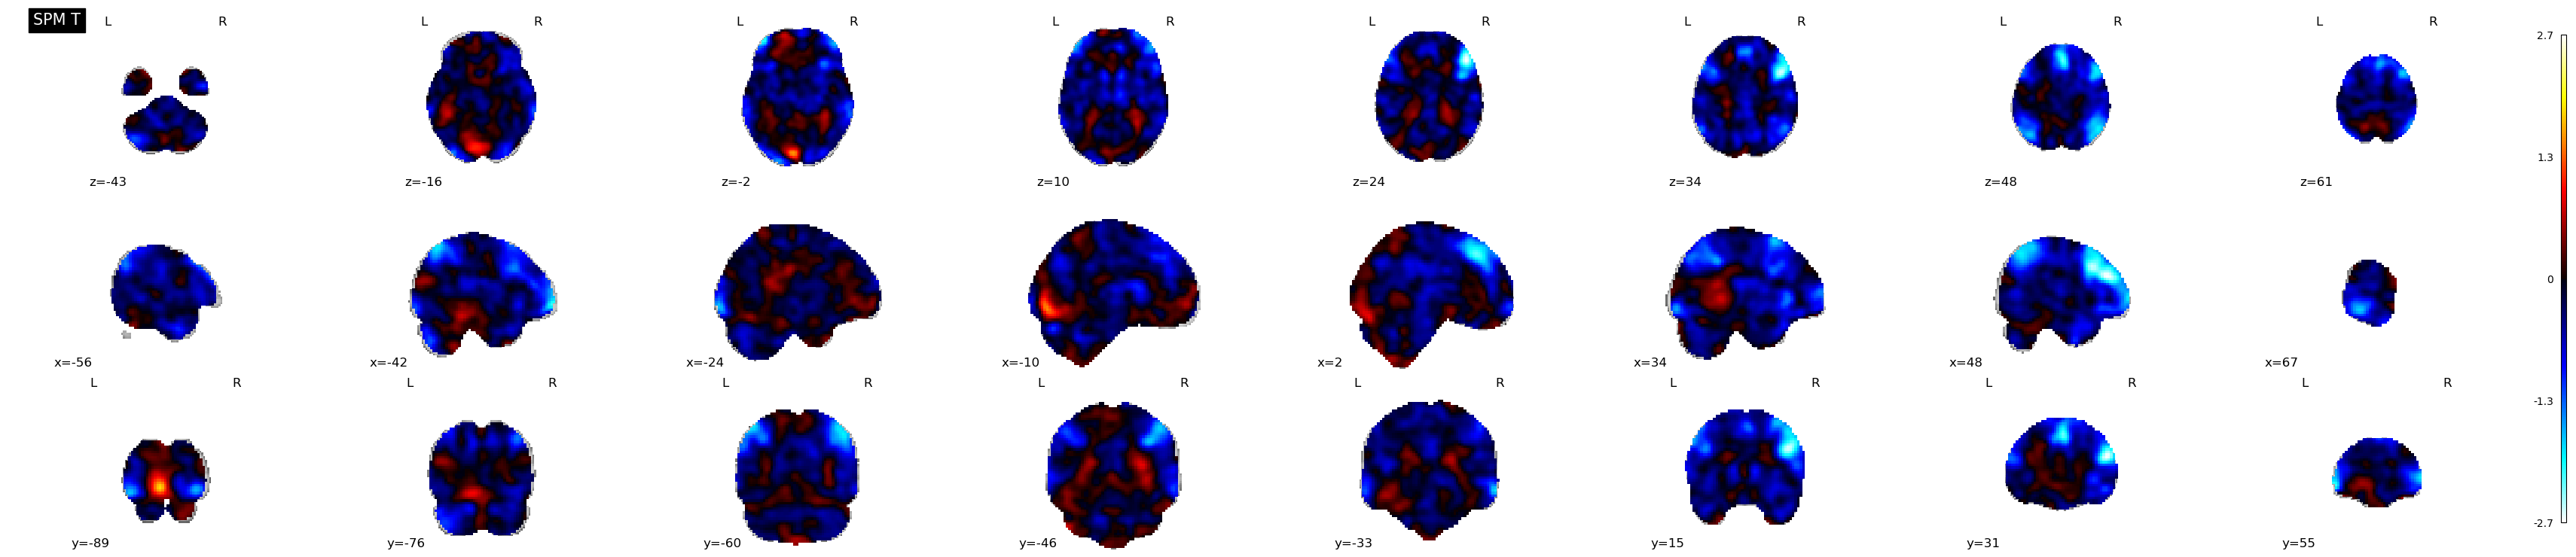

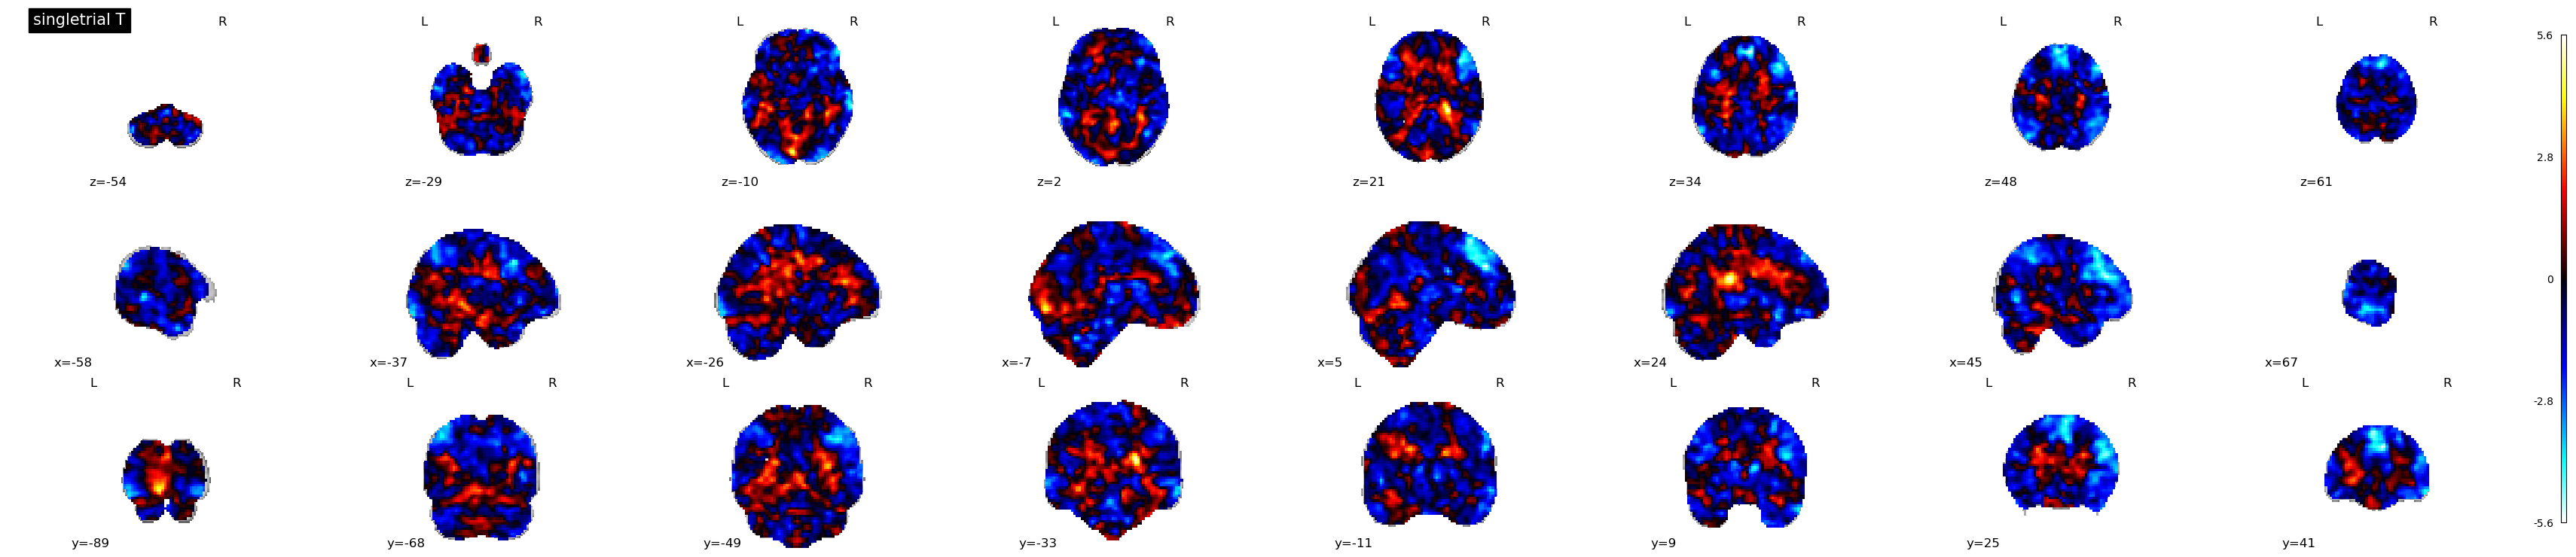

In [20]:
# plot two images
spm_tmapp = nifti_masker.inverse_transform(spmT_groupavg)
plotting.plot_stat_map(spm_tmapp, display_mode='mosaic', title='SPM T', cut_coords=8)

singletrial_tmap = nifti_masker.inverse_transform(subsettvalues)
plotting.plot_stat_map(singletrial_tmap, display_mode='mosaic', title='singletrial T', cut_coords=8)